In [20]:
import os
import sys
    
import multiprocess as mp
import numpy as np
import pandas as pd
from dask.array.chunk import coarsen

import mirnylib.plotting
import cooler
import cooltools
from cooltools import snipping, expected
import bioframe
from sklearn.mixture import GaussianMixture

import DNA_info
import matrix_manager as mm
import cooltools_pileups

from matplotlib.gridspec import GridSpec
from matplotlib import patches

%matplotlib notebook

In [4]:
res = 5000
paths = {'ESC':'/net/levsha/share/lab/U54/2019_mapping_hg38/U54_deep/upset_dots/ESC/',
         'HFF':'/net/levsha/share/lab/U54/2019_mapping_hg38/U54_deep/upset_dots/HFF/',
         'double_digest':'/net/levsha/share/lab/U54/2019_mapping_hg38/U54_deep/upset_dots/double_digest/'
        }
arms = DNA_info.get_chromosome_arms('hg38')

In [7]:
db = mm.Dataset()
table = db.get_tables()
mm.filter_data(table, filter_dict={'seq':'deep', 'celltype':'ESC'})

,lib_name,seq,celltype,xlink,enzyme,cycle
16,U54-ESC4DN-DSG-DpnII-R1-R2_hg38,deep,ESC,DSG,DpnII,NS
19,U54-H1ESC4DN-FA-DSG-MNase-R1-R2_hg38,deep,ESC,DSG,MNase,NS
26,U54-ESC4DN-FA-DpnII-R1-R2_hg38,deep,ESC,FA,DpnII,NS


In [44]:
imp.reload(mm)

db = mm.Dataset()
table = db.get_tables()

for ct in ['double_digest', 'ESC','HFF']:
    path = paths[ct]
    
    if ct == 'double_digest':
        filt_dict = {'seq':'deep', 'celltype':'HFF','xlink':'DSG'}
    else:
        filt_dict = {'seq':'deep', 'celltype':ct}
    df = mm.filter_data(table, filter_dict=filt_dict)
    df = mm.get_coolers(df, res=res)
    
    for list_file in os.listdir(path):
        list_name = list_file.split('.')[0]
        print(list_name, '\n')
        dot_list = pd.read_csv(f'{path}{list_file}', sep='\t', index_col=0).reset_index(drop=True)
        l1 = dot_list[['chrom1','start1','end1']].rename(columns=lambda x: x[0:-1])
        l1 = snipping.assign_regions(l1, arms)
        l2 = dot_list[['chrom2','start2','end2']].rename(columns=lambda x: x[0:-1])
        l2 = snipping.assign_regions(l2, arms)
        dot_list = l1.merge(l2, left_index=True, right_index=True, suffixes=('1','2'))
        dot_list = dot_list[dot_list['region1']==dot_list['region2']].reset_index(drop=True)
        dot_list['pos1'] = (dot_list['start1'] + dot_list['end1'])//2
        dot_list['pos2'] = (dot_list['start2'] + dot_list['end2'])//2
       
        binned_list1 = snipping.make_bin_aligned_windows(res, dot_list['chrom1'].values, 
                                               dot_list['pos1'].values, flank_bp=20*res)
        binned_list2 = snipping.make_bin_aligned_windows(res, dot_list['chrom2'].values, 
                                               dot_list['pos2'].values, flank_bp=20*res)
        binned_list1 = binned_list1.merge(binned_list2, left_index=True, right_index=True,
                                          suffixes=('1','2'))
        
        features = snipping.assign_regions(binned_list1, arms)
        assert np.all(features['region'].apply(lambda x: isinstance(x, str)))
        
        os.makedirs(f'pileups/dots/upset_plot/{ct}/{list_name}/', exist_ok=True)
        features.to_csv(f'pileups/dots/upset_plot/{ct}/{list_name}/{list_name}.txt', sep='\t', 
                        header=True, index=False)
        
        for i, row in df.iterrows():
            name = row['lib_name']
            print('\t', name)
            savename = f'{name}.{res}.npy'

            cool = row[f'cooler_{res}']
            snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
            with mp.Pool(20) as p:
                pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

            np.save(f'pileups/dots/upset_plot/{ct}/{list_name}/{savename}', pileup)
            print(f'Saved to: pileups/dots/upset_plot/{ct}/{list_name}/{savename}\n')
                  
        print('\n\n')
        
    break

DdeI-union-DpnII__double-digest 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 80373285) ('chr18', 18161052, 80373285

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 1816

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy




DdeI-union-DpnII__MNase 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('ch

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__MNase/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__MNase/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__MNase/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__MNase/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy




DdeI-union-DpnII 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921,

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 18161052, 80373285) ('

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 1

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy




double-digest 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0,

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18'

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 1816

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy




double-digest__MNase 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest__MNase/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest__MNase/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) (

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest__MNase/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/double-digest__MNase/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy




MNase 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('c

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/MNase/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 1816105

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/MNase/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 181

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/MNase/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/MNase/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy




DdeI-union-DpnII__double-digest__MNase 

	 U54-HFFc6-DSG-DdeI-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest__MNase/U54-HFFc6-DSG-DdeI-R1-R2_hg38.5000.npy

	 U54-HFFc6-DSG-DpnII-R1-R2_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest__MNase/U54-HFFc6-DSG-DpnII-R1-R2_hg38.5000.npy

	 U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr1

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:84: RuntimeWarning: divide by zero encountered in log10
  f = interp1d(np.log10(bin_mids), np.log10(coarse_expected), kind='linear')
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:89: RuntimeWarning: invalid value encountered in double_scalars
  yremaining = y[-1] + ((y[-1]-y[-2])/(x[-1]-x[-2]))*(xremaining - x[-1])
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: divide by zero encountered in true_divide
  matrix.data = data/fine_expected[diff]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:105: RuntimeWarning: invalid value encountered in true_divide
  matrix.data = data/fine_expected[diff]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest__MNase/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.5000.npy

	 U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


Saved to: pileups/dots/upset_plot/double_digest/DdeI-union-DpnII__double-digest__MNase/U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38.5000.npy






In [51]:
def parse_name(full_name):
    names = full_name.split('__')
    parsed_name = ''
    for name in names:
        if parsed_name != '':
            parsed_name = parsed_name+'\n'
        
        if 'MNase' in name:
            parsed_name = parsed_name+'DSG-MNase'
        elif 'FA-DpnII' in name:
            parsed_name = parsed_name+'FA-DpnII'
        elif 'DSG-DpnII' in name:
            parsed_name = parsed_name+'DSG-DpnII'
        elif 'DdeI-union-DpnII' in name:
            parsed_name = parsed_name+'DdeI-union-DpnII'
        elif 'double-digest' in name:
            parsed_name = parsed_name+'double digest'
    return parsed_name


def bootstrap_score(all_snips, 
                    score_fn=lambda x:np.mean(x[19:22,19:22])/np.mean(x[28:39,28:39]), 
                    n=1000):
    all_inds = np.arange(all_snips.shape[2])
    scores = []
    
    def func(n):
        if n % 1000 == 0:
            print(n)
            
        inds = np.random.choice(all_inds, size = all_snips.shape[2], replace=True)
        snips = all_snips[:,:,inds]
        pileup = np.nanmean(snips, axis=2)
        
        score = score_fn(pileup)
        
        return score
    
    with mp.Pool(10) as p:
        scores = list(p.map(func, np.arange(n)))
        
    return np.asarray(scores)

DdeI-union-DpnII 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
double digest 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
DSG-MNase 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
DdeI-union-DpnII
double digest 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
DdeI-union-DpnII
DSG-MNase 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
double digest
DSG-MNase 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
DdeI-union-DpnII
double digest
DSG-MNase 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000


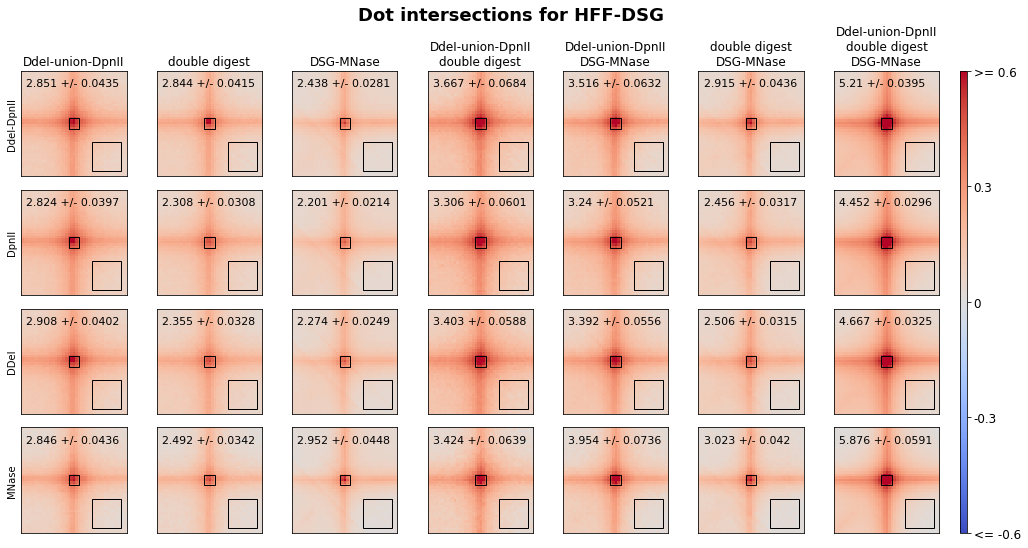

In [53]:
ct = 'double_digest'
path = paths[ct]

loadpath = f'pileups/dots/upset_plot/{ct}/'

all_lists = {parse_name(name):name for name in os.listdir(path)}

fig = plt.figure(figsize=(2*len(all_lists)+1 , 8))

fig.suptitle(f'Dot intersections for HFF-DSG', fontsize=18, fontweight='bold')
gs = GridSpec(nrows=4, ncols=len(all_lists)+1, width_ratios=[90]*len(all_lists) +[5])
lim = 0.6
for c, ax_title in enumerate(['DdeI-union-DpnII', 'double digest', 'DSG-MNase', 
                              'DdeI-union-DpnII\ndouble digest', 'DdeI-union-DpnII\nDSG-MNase',
                              'double digest\nDSG-MNase',  
                              'DdeI-union-DpnII\ndouble digest\nDSG-MNase']):

    print(ax_title,'\n')
    list_name = all_lists[ax_title].split('.')[0]
    pileup_path = f'{loadpath}{list_name}/'
    
    for file in os.listdir(pileup_path):
        if not '.npy' in file:
            continue
        
        snips = np.load(f'{pileup_path}{file}')
        pileup = np.nanmean(snips, axis=2)
#         print(np.nanmin(np.log10(pileup)), np.nanmax(np.log10(pileup)))
        
        if 'DSG-DdeI-DpnII' in file:
            ax = fig.add_subplot(gs[0,c])
            ax.set_title(ax_title)
            if not c:
                ax.set_ylabel('DdeI-DpnII')
        elif 'DSG-DpnII' in file:
            ax = fig.add_subplot(gs[1,c])
            if not c:
                ax.set_ylabel('DpnII')
        elif 'DSG-DdeI' in file:
            ax = fig.add_subplot(gs[2,c])
            if not c:
                ax.set_ylabel('DdeI')
        else:
            ax = fig.add_subplot(gs[3,c])
            if not c:
                ax.set_ylabel('MNase')
                
        scores = bootstrap_score(snips, n=5000)
        mu = np.round(np.mean(scores), 3)
        sd = np.round(np.sqrt(np.var(scores)), 4)
        ax.text(-18, -14, f'{mu} +/- {sd}', fontsize=11)
        rect = patches.Rectangle((-2,-2), 4, 4, 
                                 facecolor='none', edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        rect = patches.Rectangle((7,7), 11, 11, 
                                 facecolor='none', edgecolor='black', linewidth=1)
        ax.add_patch(rect)
    
        ax.set_xticks([])
        ax.set_yticks([])
        img = ax.imshow(np.log10(pileup), cmap='coolwarm', 
                        vmin=-lim, vmax=lim,
                       extent=[-20, 20, 20, -20])

cax = fig.add_subplot(gs[:,-1])
cbar = plt.colorbar(img, cax=cax, ticks=[-lim, -lim/2, 0, lim/2, lim])
cax.set_yticklabels([f'<= -{lim}', f'-{lim/2}', '0', f'{lim/2}', f'>= {lim}'], fontsize=12) 
fig.tight_layout(pad=3, w_pad=1, h_pad=1)
fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/dots/upset_plots/{ct}.pdf', format='pdf')
fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/dots/upset_plots/{ct}.png', format='png')

# Comparing my snipping code and cooltool's version

In [51]:
# regions = DNA_info.get_chromosome_arms('hg38')
# regions = bioframe.fetch_chromsizes('hg38')
celltype = 'HFF'
list_name = os.listdir(paths[celltype])[4].split('.')[0]
list_path = paths[celltype]+list_name+'.txt'
print(list_path)

db = mm.Dataset()
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'celltype':celltype, 'seq':'deep'})
table = mm.get_coolers(table, res=res)
display(table)
ind = np.random.choice(table.index.values)
name = table.loc[ind, 'lib_name']
print(name)
cool = table.loc[ind, f'cooler_{res}']

supports = [(chrom, 0, cool.chromsizes[chrom]) for chrom in cool.chromnames]
regions = supports
transforms = {"balanced": lambda p: p["count"] * p['weight1'] * p['weight2']}
with mp.Pool(15) as p:
    result = expected.diagsum(cool, supports, transforms=transforms, map=p.map)
expt = pd.concat(
                [result[support] for support in supports],
                keys=[support[0] for support in supports],
                names=["chrom"],
            )
expt = expt.reset_index()
expt["count.avg"] = expt["count.sum"] / expt["n_valid"]
for key in transforms.keys():
    expt[key + ".avg"] = expt[key + ".sum"] / expt["n_valid"]

display(expt.head())

/net/levsha/share/lab/U54/2019_mapping_hg38/U54_deep/upset_dots/HFF/U54-HFFc6-FA-DSG-MNase-R1-R3_hg38__U54-HFFc6-FA-DpnII-R1-R2_hg38.txt


,lib_name,seq,celltype,xlink,enzyme,cycle,cooler_5000
0,U54-HFFc6-DSG-DdeI-R1-R2_hg38,deep,HFF,DSG,DdeI,NS,"<Cooler ""U54-HFFc6-DSG-DdeI-R1-R2_hg38.hg38.ma..."
1,U54-HFFc6-DSG-DpnII-R1-R2_hg38,deep,HFF,DSG,DpnII,NS,"<Cooler ""U54-HFFc6-DSG-DpnII-R1-R2_hg38.hg38.m..."
2,U54-HFFc6-FA-DSG-MNase-R1-R3_hg38,deep,HFF,DSG,MNase,NS,"<Cooler ""U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.hg3..."
3,U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38,deep,HFF,DSG,double,NS,"<Cooler ""U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-..."
4,U54-HFFc6-FA-DpnII-R1-R2_hg38,deep,HFF,FA,DpnII,NS,"<Cooler ""U54-HFFc6-FA-DpnII-R1-R2_hg38.hg38.ma..."


U54-HFFc6-DSG-DdeI-R1-R2_hg38


,chrom,diag,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr1,0,42283,NaN,NaN,NaN,NaN
1,chr1,1,41461,NaN,NaN,NaN,NaN
2,chr1,2,41391,10117222.0,1640.766522,244.430480,0.039641
3,chr1,3,41340,6289777.0,1021.010518,152.147484,0.024698
4,chr1,4,41314,4538649.0,737.220950,109.857409,0.017844


<IPython.core.display.Javascript object>


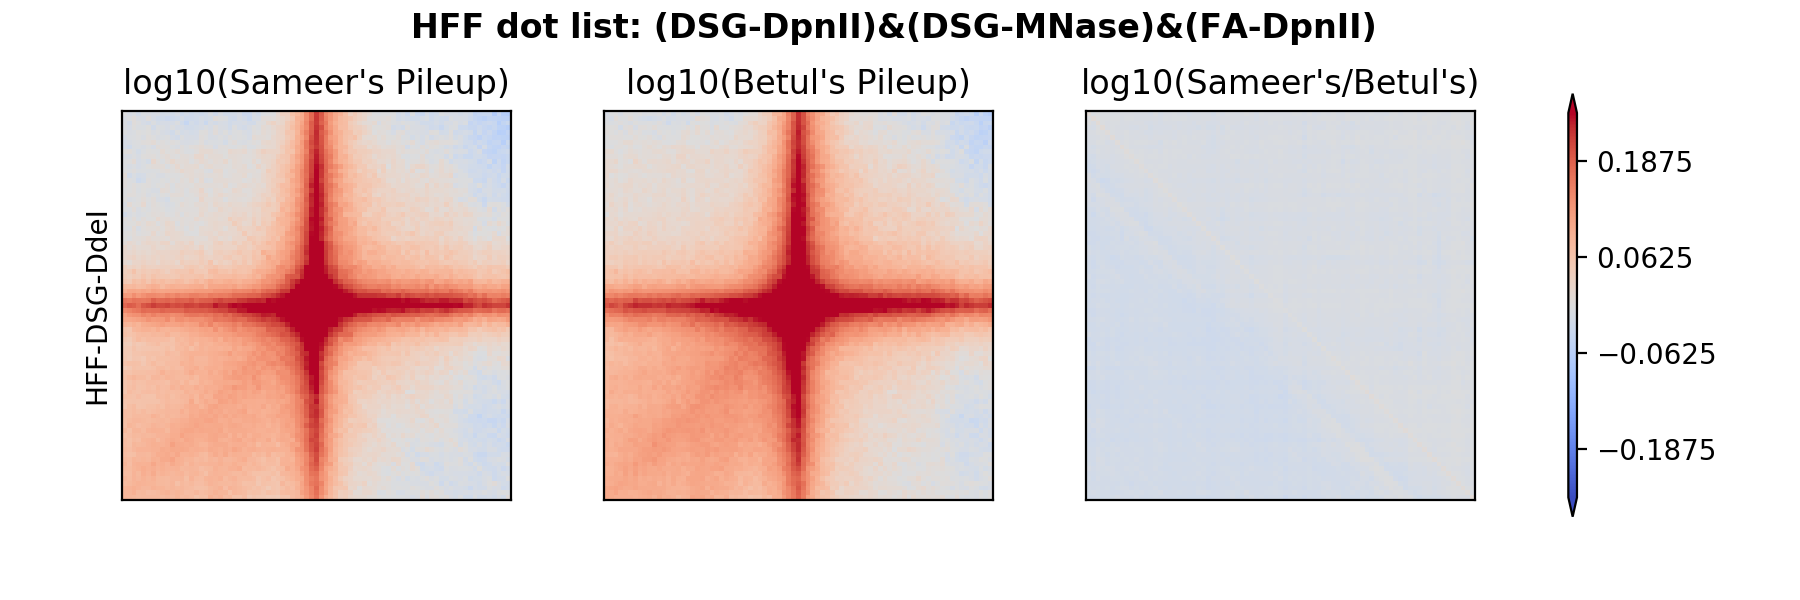

('chr1', 0, 248956422) ('chr1', 0, 248956422)
('chr10', 0, 133797422) ('chr10', 0, 133797422)
('chr11', 0, 135086622) ('chr11', 0, 135086622)
('chr12', 0, 133275309) ('chr12', 0, 133275309)
('chr14', 0, 107043718) ('chr14', 0, 107043718)
('chr13', 0, 114364328) ('chr13', 0, 114364328)
('chr16', 0, 90338345) ('chr16', 0, 90338345)
('chr15', 0, 101991189) ('chr15', 0, 101991189)
('chr17', 0, 83257441) ('chr17', 0, 83257441)
('chr19', 0, 58617616) ('chr19', 0, 58617616)
('chr18', 0, 80373285) ('chr18', 0, 80373285)
('chr2', 0, 242193529) ('chr2', 0, 242193529)
('chr20', 0, 64444167) ('chr20', 0, 64444167)
('chr21', 0, 46709983) ('chr21', 0, 46709983)
('chr22', 0, 50818468) ('chr22', 0, 50818468)
('chr3', 0, 198295559) ('chr3', 0, 198295559)
('chr4', 0, 190214555) ('chr4', 0, 190214555)
('chr5', 0, 181538259) ('chr5', 0, 181538259)
('chr6', 0, 170805979) ('chr6', 0, 170805979)
('chr7', 0, 159345973) ('chr7', 0, 159345973)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr8', 0, 145138636) ('chr8', 0, 145138636)
('chr9', 0, 138394717) ('chr9', 0, 138394717)
('chrX', 0, 156040895) ('chrX', 0, 156040895)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


In [54]:
dot_list = pd.read_csv(list_path, sep='\t', index_col=0).reset_index(drop=True)
l1 = dot_list[['chrom1','start1','end1']].rename(columns=lambda x: x[0:-1])
l1 = snipping.assign_regions(l1, regions)
l2 = dot_list[['chrom2','start2','end2']].rename(columns=lambda x: x[0:-1])
l2 = snipping.assign_regions(l2, regions)
dot_list = l1.merge(l2, left_index=True, right_index=True, suffixes=('1','2'))
dot_list = dot_list[dot_list['region1']==dot_list['region2']].reset_index(drop=True)
dot_list['pos1'] = (dot_list['start1'] + dot_list['end1'])//2
dot_list['pos2'] = (dot_list['start2'] + dot_list['end2'])//2

binned_list1 = snipping.make_bin_aligned_windows(res, dot_list['chrom1'].values, 
                                       dot_list['pos1'].values, flank_bp=40*res)
binned_list2 = snipping.make_bin_aligned_windows(res, dot_list['chrom2'].values, 
                                       dot_list['pos2'].values, flank_bp=40*res)
binned_list1 = binned_list1.merge(binned_list2, left_index=True, right_index=True,
                                  suffixes=('1','2'))

features = snipping.assign_regions(binned_list1, regions)
assert np.all(features['region'].apply(lambda x: isinstance(x, str)))

fig = plt.figure(figsize=(9, 3))
fig.suptitle(f'{celltype} dot list: (DSG-DpnII)&(DSG-MNase)&(FA-DpnII) ', fontweight='bold')
gs = GridSpec(nrows=1, ncols=4, width_ratios=[90,90,90, 2])

snipper = cooltools_pileups.LocalObsExpSnipper(cool)#, cooler_opts={'balance':True})
with mp.Pool(20) as p:
    snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)
    
pileup1 = np.nanmean(snips, axis=2)

ax = fig.add_subplot(gs[0])
ax.set_title("log10(Sameer's Pileup)")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel(f'{celltype}-DSG-DdeI')

lim = 0.25
img = ax.imshow(np.log10(pileup1), cmap='coolwarm', 
                        vmin=-lim, vmax=lim,
                       extent=[-20, 20, 20, -20])

snipper = snipping.ObsExpSnipper(cool, expt)#, cooler_opts={'balance':True})
with mp.Pool(20) as p:
    snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)
    
pileup2 = np.nanmean(snips, axis=2)

ax = fig.add_subplot(gs[1])
ax.set_title("log10(Betul's Pileup)")
ax.set_xticks([])
ax.set_yticks([])

img = ax.imshow(np.log10(pileup2), cmap='coolwarm', 
                        vmin=-lim, vmax=lim,
                       extent=[-20, 20, 20, -20])

ax = fig.add_subplot(gs[2])
ax.set_title("log10(Sameer's/Betul's)")
ax.set_xticks([])
ax.set_yticks([])

img = ax.imshow(np.log10(pileup1/pileup2), cmap='coolwarm', 
                        vmin=-lim, vmax=lim,
                       extent=[-20, 20, 20, -20])

cax = fig.add_subplot(gs[3])
cbar = plt.colorbar(img, cax=cax, ticks=[-3*lim/4, -lim/4, lim/4, 3*lim/4], extend='both') 
fig.tight_layout(pad=3)
fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/dot_pileup_comparison.png', format='png')